This is how much space the figure will take up on letter paper


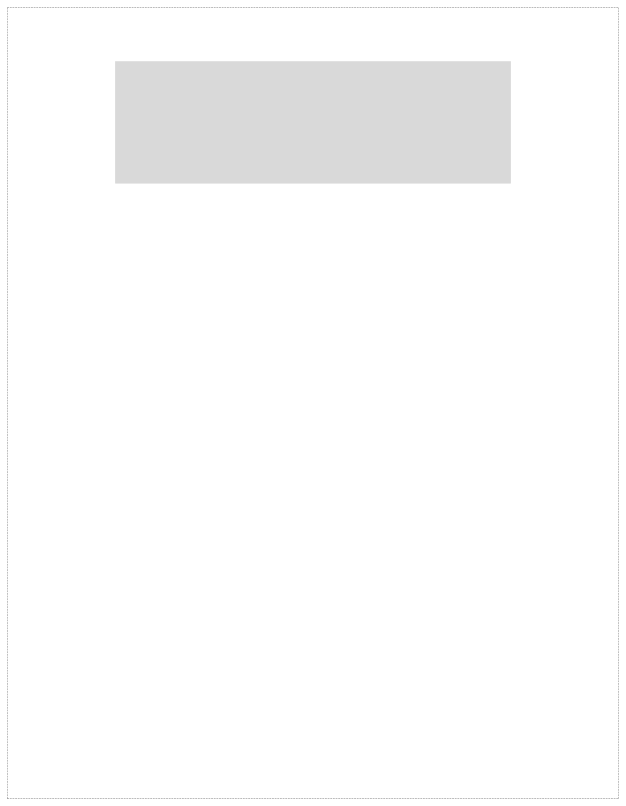

In [1]:
__PRODUCTION__ = 0
__NAME__       = 'optimization'
__WIDTH__      = 5.5  # NeurIPS 2021 text box width
__HEIGHT__     = 1.7

if __PRODUCTION__:
    from mplmagic import pgf
else:
    from mplmagic import svg

from mplmagic.util import SuperFigure, SuperAxes, size_hint
import matplotlib.pyplot as plt

print('This is how much space the figure will take up on letter paper')
size_hint(__WIDTH__, __HEIGHT__, margin_left=0.5 * (8.5 - __WIDTH__));

In [2]:
import matplotlib.pyplot as plt
import functools
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.spatial.distance import cdist
import torch
import torch.nn.functional as F
from torch import optim
import pickle

from symfac.experimental import RBFExpansionPlus
from symfac.experimental import RBFExpansionMiniBatchPlus

/home/symfac/.local/lib/python3.8/site-packages/matplotlib/textpath.py:90: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/home/symfac/.local/lib/python3.8/site-packages/matplotlib/textpath.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  glyph = font.load_char(ccode, flags=LOAD_NO_HINTING)


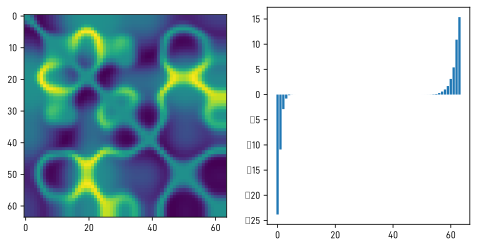

[0.12843, 0.07073, 0.04168, 0.0127, 0.0056, 0.00325, 0.00121, 0.00052, 0.00027]


In [3]:
def rbf(X, Y=None):
    return np.exp(-np.subtract.outer(X, Y if Y is not None else X)**2)

n = 64

np.random.seed(78963)
u = 5 * np.random.randn(n)
v = 4 * np.random.randn(n)
U = gaussian_filter1d(u, 3., order=0)
V = gaussian_filter1d(v, 6., order=0)

K = rbf(U) - rbf(V)
Kt = torch.tensor(K, dtype=torch.float32)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(K)
axs[1].bar(np.arange(n), np.linalg.eigvalsh(K))
plt.show()

U, S, V = np.linalg.svd(K)
svd_K = []
for k in range(1, 10):
    truncation = (U[:, :k] * S[None, :k]) @ V[:k, :]
    svd_K.append(round(float(F.mse_loss(torch.tensor(truncation), torch.tensor(K))), 5))
print(svd_K)

In [4]:
optimizers = ['SGD', 'Adam', 'Adadelta', 'Adagrad', 'RMSprop', 'ASGD', 'AdamW']

all_loss.max 0.03695562481880188


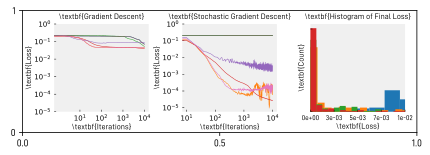

In [5]:
fig = SuperFigure(plt.figure(figsize=(__WIDTH__, __HEIGHT__), dpi=300))
ax_canvas = fig.make_axes(
    left=0, right=1, top=0, bottom=1, zorder=-100,
    style='blank' if __PRODUCTION__ else None
)
ax_canvas.set_xlim([0, 1])
ax_canvas.set_ylim([0, 1])

# draw the axes grid
x0 = 0.08
y0 = 0.11
dx = 0.325
w = 0.24
h = 0.72
axs = [
    fig.make_axes(
        left=x0 + dx * i,
        top=y0,
        width=w,
        height=h,
        style='modern'
    ) for i in range(3)
]

tick_style = dict(
    fontsize=7
)
label_style = dict(
    fontsize=8,
    labelpad=0.5
    
)

# GD
def plot_gradient_descent(ax):
    for opt in optimizers:
        fac = RBFExpansionPlus.from_pickle(
            f'data/optimization-gradient-descent-{opt}.pickle'
        )
        ax.plot(
            fac.report.loss_history_ticks,
            fac.report.loss_history.min(axis=1),
            label=opt
        )
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    xticks = np.logspace(1, 4, 4)
    ax.set_xticks(xticks)
    ax.set_xticklabels(
        [fr'$10^{np.log10(x):.0f}$' for x in xticks],
        **tick_style
    )
    yticks = np.logspace(0, -5, 6)
    ax.set_yticks(yticks)
    ax.set_yticklabels(
        [fr'$10^{{{np.log10(y):.0f}}}$' for y in yticks],
        **tick_style
    )
    
    ax.set_xlabel(r'\textbf{Iterations}', **label_style)
    ax.set_ylabel(r'\textbf{Loss}', **label_style)


plot_gradient_descent(axs[0])


# SGD
def plot_stochastic_gradient_descent(ax):
    for opt in optimizers:
        fac = RBFExpansionMiniBatchPlus.from_pickle(
            f'data/optimization-stochastic-gradient-descent-{opt}.pickle'
        )
        ax.plot(
            fac.report.loss_history_ticks,
            fac.report.loss_history.min(axis=1),
            label=opt
        )
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    xticks = np.logspace(1, 4, 4)
    ax.set_xticks(xticks)
    ax.set_xticklabels(
        [fr'$10^{np.log10(x):.0f}$' for x in xticks],
        **tick_style
    )
    yticks = np.logspace(0, -5, 6)
    ax.set_yticks(yticks)
    ax.set_yticklabels(
        [fr'$10^{{{np.log10(y):.0f}}}$' for y in yticks],
        **tick_style
    )
    
    ax.set_xlabel(r'\textbf{Iterations}', **label_style)
    ax.set_ylabel(r'\textbf{Loss}', **label_style)

plot_stochastic_gradient_descent(axs[1])


def plot_final_loss_histogram(ax):
    all_loss = []
    for zoom in [1.0, 0.1, 0.01, 0.001]:
        fac = RBFExpansionMiniBatchPlus.from_pickle(
            f'data/optimization-GD-zoom-{zoom}.pickle'
        )
        
        ax.hist(fac.report.loss_best, label=f'zoom {zoom:e}', bins=20)
        
        all_loss += fac.report.loss_best.numpy().tolist()

    all_loss = np.array(all_loss)
    print('all_loss.max', all_loss.max())
    xticks = np.linspace(0, 0.01, 5)
    ax.set_xbound(lower=0, upper=1e-2)
    ax.set_xticks(xticks)
    ax.set_xticklabels(
        ['%.0e' % x for x in xticks],
        **tick_style
    )
    ax.set_yticklabels(
        ax.get_yticklabels(),
        **tick_style
    )
    
    ax.set_xlabel(r'\textbf{Loss}', **label_style)
    ax.set_ylabel(r'\textbf{Count}', **label_style)
    
        
plot_final_loss_histogram(axs[2])

title_style = dict(
    fontsize=8,
    y=0.975,
    va='bottom'
)
axs[0].set_title(r'\textbf{Gradient Descent}', **title_style)
axs[1].set_title(r'\textbf{Stochastic Gradient Descent}', **title_style)
axs[2].set_title(r'\textbf{Histogram of Final Loss}', **title_style)


# best_run = torch.argmin(fac.report.loss_best)

# image_styles = dict(
#     cmap='Greys_r'
# )
# axs[0].imshow(K, **image_styles)
# axs[1].imshow(K_svd1, **image_styles)
# axs[2].imshow(fac.optimum(runs=best_run), **image_styles)

# tick_style = dict(
#     fontsize=7
# )
# for ax in axs[:3]:
#     ax.patch.set_facecolor('w')
#     ax.set_xbound(lower=0, upper=K.shape[0])
#     ax.set_ybound(lower=0, upper=K.shape[1])
#     xticks = np.array([0, K.shape[0]])
#     ax.set_xticks(xticks)
#     ax.set_yticks([])
#     ax.tick_params(axis='both', which='both', length=0)
#     ax.set_xticklabels(['%d' % x for x in xticks], **tick_style)
#     # ax.set_yticklabels(['%d' % y for y in K.shape[1] - yticks], **tick_style)
#     ax.set_xlabel(r'\textbf{Node ID}', fontsize=8, va='bottom')

# starts = np.concatenate(([0], np.cumsum(sizes)))
# u = fac.optimum.u[best_run, :, 0].cpu().numpy()
# u = (u - u.min()) / (u.max() - u.min())  # normalize to 0-1
# for i, (beg, end) in enumerate(zip(starts[:-1], starts[1:])):
#     axs[3].scatter(
#         np.arange(beg, end),
#         u[beg:end],
#         s=8.0,
#         marker='o',
#         color=colorsys.hls_to_rgb(i * 0.125, 0.45, 1.0),
#         # edgecolor='w',
#         edgecolor=colorsys.hls_to_rgb(i * 0.125, 0.3, 1.0),
#         linewidth=.5
#     )
# axs[3].set_ylabel(r'\textbf{Embedded Coordinate}', fontsize=8)
# axs[3].set_xbound(lower=-4, upper=K.shape[0] + 4)
# axs[3].set_ybound(lower=-0.2, upper=1.2)
# xticks = np.array([0, K.shape[0]])
# axs[3].set_xticks(xticks)
# axs[3].set_yticks([0, 1])
# axs[3].tick_params(axis='both', which='both', length=0)
# axs[3].set_xticklabels(['%d' % x for x in xticks], **tick_style)
# axs[3].set_yticklabels([0, 1], **tick_style)
# axs[3].set_xlabel(r'\textbf{Node ID}', fontsize=8, va='bottom')

# title_style = dict(
#     fontsize=8,
#     y=0.975,
#     va='bottom'
# )
# axs[0].set_title(r'\textbf{Original Adjacency Matrix}', **title_style)
# axs[1].set_title(r'\textbf{One SVD Rank}', **title_style)
# axs[2].set_title(r'\textbf{One RBF Component}', **title_style)
# axs[3].set_title(r'\textbf{Normalized RBF Embedding}', **title_style)


if __PRODUCTION__:
    fig.savefig(f'pgf/{__NAME__}.pgf', dpi=300)
else:
    fig.savefig(f'svg/{__NAME__}.svg', dpi=300)
plt.show()

In [6]:
!make -f Makefile.figures fig-"$__NAME__".pdf 2>&1 | tail -n 1

Successfully created fig-optimization.pdf
